In [ ]:
# load vae and cluster patches of the latent space

In [1]:
import sys
import os

# Add particle_detection to sys.path
sys.path.append(os.path.abspath(".."))

In [2]:
import os
import numpy as np
import cv2

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

from sklearn.mixture import GaussianMixture

from particle_detection.data.data_pipeline import create_dataloaders
from particle_detection.autoencoder.model import create_autoencoder
from particle_detection.vae.model import create_vae
from particle_detection.utils.model_utils import load_model
from particle_detection.clustering.cluster_visualization import process_and_visualize_clusters, visualize_binary_clusters, compare_original_and_clusters
from particle_detection.utils.pca_preprocessing import apply_pca, plot_explained_variance

In [3]:
data_dir = "../data"
#data_dir = "/home/blah-buttery/nanoparticles/images/normal" # gpu ws 
#dataset_dir = "/Users/blah_m4/Desktop/nanoparticle/images" # macbook
image_size = (2048, 2048)
batch_size = 8

train_loader, test_loader = create_dataloaders(data_dir=data_dir, image_size=image_size, batch_size=batch_size)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = create_vae("../saved_models/ae_1001_1024x1024/model.pth")
vae = load_model(vae, "../saved_models/vae_100_128x128/model.pth", device=device)
vae = vae.to(device)
vae.eval()
print("model loaded successfully.")

Loading model from: ../saved_models/vae_100_128x128/model.pth
Model loaded successfully from ../saved_models/vae_100_128x128/model.pth.
model loaded successfully.


In [5]:
def extract_patches(image, patch_size=16):
    patches = []
    _, height, width = image.shape

    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            patch = image[:, i:i + patch_size, j:j + patch_size]
            
            #print(f"Extracted patch shape: {patch.shape} at ({i}, {j})")

            if patch.shape[1] == patch_size and patch.shape[2] == patch_size:  # we should always have a full patch
                patches.append(patch)

    return patches

In [6]:
def extract_latent_representations_for_patches(data_loader, patch_size=16):
    vae.eval()
    latent_representations = []
    patch_coordinates = []

    with torch.no_grad():
        for img_idx, img in enumerate(data_loader):
            img = img[0].to(device)

            #print(f"Full image {img_idx} shape before patching: {img.shape}")

            patches = extract_patches(img, patch_size)

            for idx, patch in enumerate(patches):
                #print(f"Patch {idx} shape before adding batch dim: {patch.shape}")  # Debugging

                patch = patch.unsqueeze(0).to(device)  # Add batch dimension

                #print(f"Patch {idx} shape after adding batch dim: {patch.shape}")  # Debugging
                resized_patch = F.interpolate(patch, size=(128, 128), mode="bilinear", align_corners=False)

                #latent_vector = vae.encode(patch)
                latent_vector = vae.encode(resized_patch)

                #print(f"Latent vector shape: {latent_vector.shape}")  # Debugging

                latent_representations.append(latent_vector.cpu().numpy())
                patch_coordinates.append((idx, img.shape[1], img.shape[2]))  # Track position for reconstruction

    return np.concatenate(latent_representations), patch_coordinates

In [7]:
def visualize_clusters(img, patch_coordinates, cluster_labels, patch_size=16):
    height, width = img.shape[1], img.shape[2] 
    clustered_image = np.zeros((height, width))

    num_patches_w = width // patch_size

    for idx, (coord, h, w) in enumerate(patch_coordinates):
        i = (coord // num_patches_w) * patch_size
        j = (coord % num_patches_w) * patch_size

        # Assign cluster labels
        clustered_image[i:i + patch_size, j:j + patch_size] = cluster_labels[idx]

    plt.figure(figsize=(10, 10))
    plt.imshow(clustered_image, cmap="viridis")
    plt.colorbar()
    plt.title("Nanoparticle Clusters")
    plt.show()

    return clustered_image

In [8]:
def plot_cluster_contours(sample_img, binary_cluster_labels_grid, cluster_id=None, title="Cluster Contours"):

    if sample_img.shape[0] == 3:
        image_np = sample_img.permute(1, 2, 0).cpu().numpy()
        image_np = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY) 
    else:
        image_np = sample_img[0].cpu().numpy()

    image_np = (image_np - image_np.min()) / (image_np.max() - image_np.min()) * 255
    image_np = image_np.astype(np.uint8)

    resized_binary_mask = cv2.resize(binary_cluster_labels_grid, (image_np.shape[1], image_np.shape[0]), interpolation=cv2.INTER_NEAREST)

    # option to print all clusters or just one specific cluster label
    if cluster_id is not None:
        mask = (resized_binary_mask == cluster_id).astype(np.uint8)
    else:
        mask = (resized_binary_mask > 0).astype(np.uint8)

    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # might not need
    overlay = cv2.cvtColor(image_np, cv2.COLOR_GRAY2BGR)

    cv2.drawContours(overlay, contours, -1, (255, 0, 0), 1)

    plt.figure(figsize=(10, 10))
    plt.imshow(overlay)
    plt.title(f"Cluster {cluster_id}" if cluster_id is not None else "All Clusters")
    plt.axis("off")
    plt.show()

In [9]:
patch_size=16

In [10]:
latent_representations, patch_coordinates = extract_latent_representations_for_patches(test_loader, patch_size=patch_size)

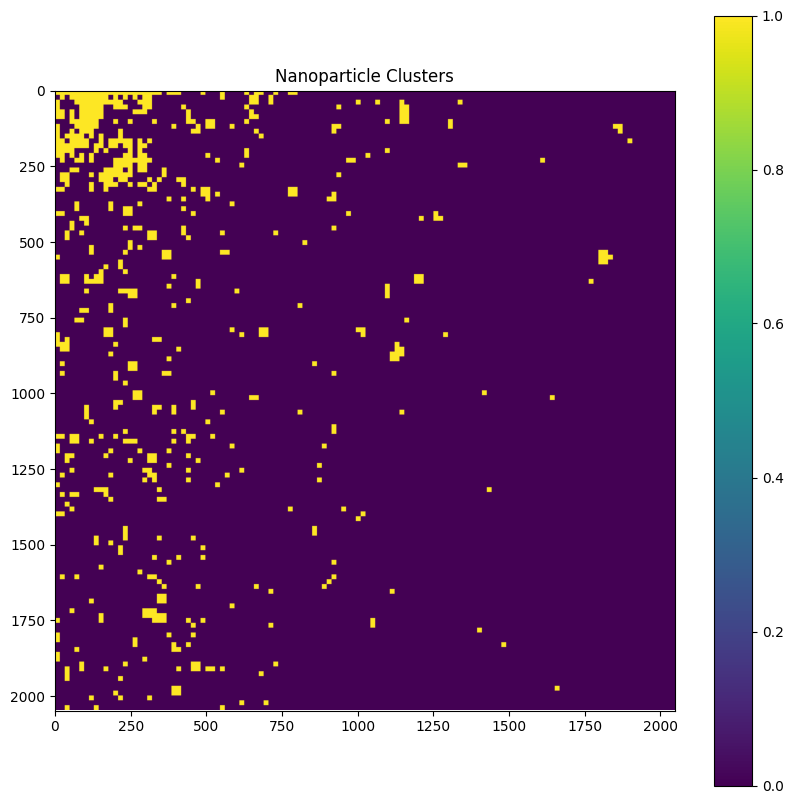

In [23]:
# single gmm with patches
gmm = GaussianMixture(n_components=3, random_state=42, covariance_type="full")
gmm.fit(latent_representations)
cluster_labels = gmm.predict(latent_representations)

unique_clusters = set(cluster_labels)
particle_group_label = min(unique_clusters, key=list(cluster_labels).count)
binary_cluster_labels = [1 if label == particle_group_label else 0 for label in cluster_labels]

sample_img = next(iter(test_loader)).to(device)
clustered_image = visualize_clusters(sample_img[0].cpu(), patch_coordinates, binary_cluster_labels)

In [24]:
H, W = sample_img.shape[2], sample_img.shape[3]
grid_h = H // patch_size
grid_w = W // patch_size

cluster_labels_grid = np.array(binary_cluster_labels).reshape(grid_h, grid_w)

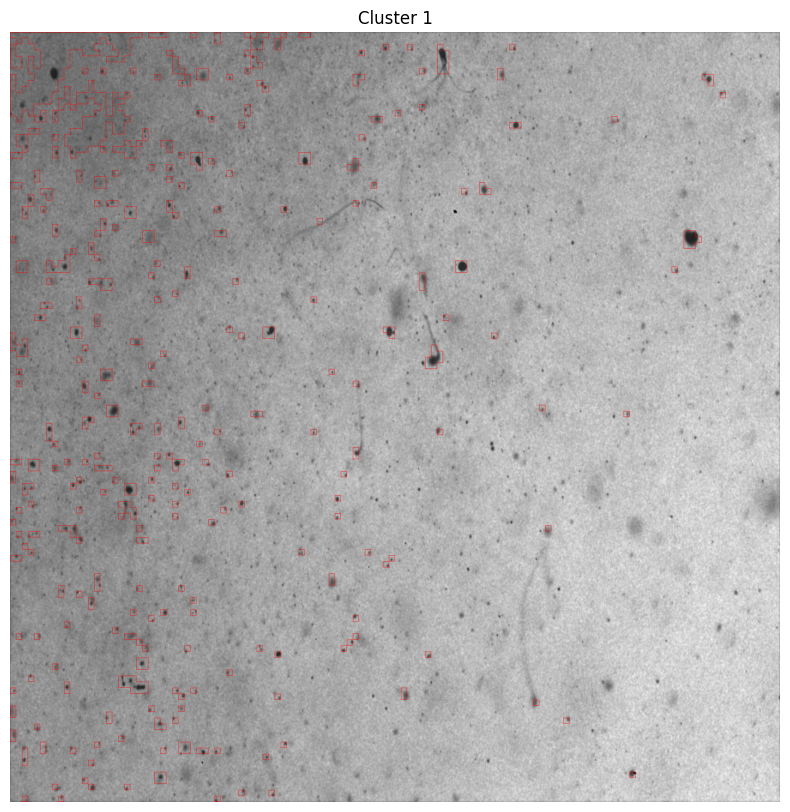

In [25]:
plot_cluster_contours(
    sample_img[0],
    binary_cluster_labels_grid=cluster_labels_grid,
    cluster_id=1,
)